<a href="https://colab.research.google.com/github/hnstn/smartlabs/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from google.colab import drive

# Importing data
drive.mount('/content/drive')
meat_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Kaggletutorial/Cópia de banco_colider(inteiro).xlsx')
meat_data = meat_data.dropna(axis=0)
meat_data.describe()

Mounted at /content/drive


,N,Peso_Abate,PCQ,PCQ_arroba,RCQ_porcentagem,Dente,EGSD,AOLm,AOL_PV,AOL_PCQ,...,M2D0I,M2D0J,M2D0K,M2D0L,M2D0R,M2D0S,M2D0T,M2D0U,M2D0V,M2D0W
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,4.400000e+01,44.0,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,22.659091,615.409091,352.170455,23.478030,0.572494,0.454545,4.425000,87.328397,14.198822,24.793763,...,2.851818,0.354091,6.200000e-01,0.0,1.186591,4.235682,0.649091,0.687273,0.540000,1.213182
std,13.082819,24.858968,13.483816,0.898921,0.015139,0.847830,1.806207,8.268832,1.307240,2.091688,...,0.530131,0.096889,2.246117e-16,0.0,0.176384,0.799274,0.356089,0.327729,0.433439,0.246527
min,1.000000,554.000000,317.000000,21.133333,0.530395,0.000000,1.700000,72.170335,12.296667,21.738053,...,2.000000,0.000000,6.200000e-01,0.0,1.160000,3.110000,0.000000,0.000000,0.000000,1.160000
25%,11.750000,602.000000,348.000000,23.200000,0.563099,0.000000,3.200000,81.546521,13.090854,23.041504,...,2.400000,0.380000,6.200000e-01,0.0,1.160000,4.140000,0.840000,0.840000,0.000000,1.160000
50%,22.500000,613.000000,352.750000,23.516667,0.576810,0.000000,3.950000,85.781675,14.169152,24.046049,...,2.810000,0.380000,6.200000e-01,0.0,1.160000,4.140000,0.840000,0.840000,0.880000,1.160000
75%,33.250000,628.000000,358.250000,23.883333,0.580928,0.000000,5.100000,91.318505,15.011708,26.689331,...,3.210000,0.380000,6.200000e-01,0.0,1.160000,4.140000,0.840000,0.840000,0.880000,1.160000
max,45.000000,690.000000,389.000000,25.933333,0.603821,2.000000,11.600000,106.593930,17.021759,29.528058,...,4.010000,0.380000,6.200000e-01,0.0,2.330000,7.250000,0.840000,0.840000,0.880000,2.330000


In [2]:
meat_data.columns
#y = meat_data.SF_0D_MediaGeral
#meat_features = ['pH_Lab_0d','AOLm','AOL_PCQ','LarguraOL','Cor_Score_Lab_0d']
#X = meat_data[meat_features]

meat_features = ['SF_0D_MediaGeral','pH_Lab_0d','AOLm','AOL_PCQ','LarguraOL','Cor_Score_Lab_0d']
X = meat_data[meat_features]

df_train = X.sample(frac=0.7, random_state=0)
df_valid = X.drop(df_train.index)
display(df_train.head(4))

# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

# Split features and target
X_train = df_train.drop('SF_0D_MediaGeral', axis=1)
X_valid = df_valid.drop('SF_0D_MediaGeral', axis=1)
y_train = df_train['SF_0D_MediaGeral']
y_valid = df_valid['SF_0D_MediaGeral']

,SF_0D_MediaGeral,pH_Lab_0d,AOLm,AOL_PCQ,LarguraOL,Cor_Score_Lab_0d
30,3710.83,5.95,76.917450,22.790356,15.4101,7.0
38,3594.41,5.49,98.089115,27.905865,15.8714,6.0
27,5280.85,5.76,91.476020,26.061544,15.0155,6.0
4,3163.62,6.13,72.170335,21.738053,13.7137,4.0


In [3]:
preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse=False),
     make_column_selector(dtype_include=object)),
)

In [4]:
X = preprocessor.fit_transform(X)
#y = np.log(y) # log transform target instead of standardizing

input_shape = [X.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [6]


In [5]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[5]),                                             
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.3),
    #layers.BatchNormalization(), 
    layers.Dense(32, activation='relu'),
    #layers.Dropout(0.3),
    #layers.BatchNormalization(),    
    layers.Dense(8, activation='relu'),
    #layers.Dropout(0.3),
    #layers.BatchNormalization(), 
    layers.Dense(1),
])

In [6]:
model.compile(
    optimizer = "sgd",
    loss = "mae",
    metrics = ['mae'],
)

In [7]:
history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size =180,
    epochs =1200,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

Minimum validation loss: 0.10526382923126221


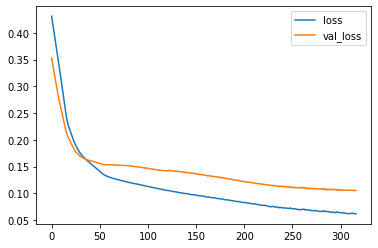

In [8]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

You probably saw that smaller batch sizes gave noisier weight updates and loss curves. This is because each batch is a small sample of data and smaller samples tend to give noisier estimates. Smaller batches can have an "averaging" effect though which can be beneficial.

Smaller learning rates make the updates smaller and the training takes longer to converge. Large learning rates can speed up training, but don't "settle in" to a minimum as well. When the learning rate is too large, the training can fail completely.